In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet

In [28]:
trades = pd.read_parquet("clean_trades.parquet", engine = 'fastparquet')
df = pd.read_csv("baseline2.csv",index_col='Unnamed: 0')

In [29]:
df

,stock_id,time_id,sigma,target,size,spread,time_diff,log_time_diff,timefunc
0,0,5,0.004499,0.004136,3179,7.922559,15,2.708050,0.310975
1,0,11,0.001204,0.001445,1287,4.118409,23,3.135494,0.723982
2,0,16,0.002369,0.002168,2161,6.476585,35,3.555348,0.971598
3,0,31,0.002574,0.002195,1962,7.627233,28,3.332205,0.849035
4,0,62,0.001894,0.001747,1791,4.302926,25,3.218876,0.779443
...,...,...,...,...,...,...,...,...,...
428905,126,32751,0.003691,0.003461,2570,8.478007,13,2.564949,0.309585
428906,126,32753,0.004104,0.003113,2085,6.312181,22,3.091042,0.788629
428907,126,32758,0.003118,0.004070,3740,7.187954,24,3.178054,0.841990
428908,126,32763,0.003661,0.003357,9389,5.191397,4,1.386294,1.040582


In [30]:
trades.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id,bid_price1,ask_price1,bid_price2,ask_price2,...,bid_price2_before,ask_price2_before,bid_size1_before,ask_size1_before,bid_size2_before,ask_size2_before,time_diff,trade,mid,spread
index,,,,,,,,,,,,,,,,,,,,,
0,5,21,1.002301,326,12,0,1.001422,1.002818,1.001370,1.002922,...,1.001370,1.002405,3,126,2,100,2,1,1.002120,13.933441
1,5,46,1.002778,128,4,0,1.002818,1.003232,1.002301,1.003801,...,1.001422,1.002922,83,28,3,100,2,0,1.003025,4.125274
2,5,50,1.002818,55,1,0,1.002353,1.003025,1.002301,1.003232,...,1.002353,1.003749,55,101,103,100,2,-1,1.002689,6.705371
3,5,57,1.003155,121,5,0,1.002508,1.003646,1.002457,1.003749,...,1.002301,1.003181,3,20,100,100,2,1,1.003077,11.342434
4,5,68,1.003646,4,1,0,1.002870,1.003749,1.002818,1.003801,...,1.002767,1.003749,11,4,14,200,5,1,1.003310,8.762683


In [31]:
trades['w_spread'] = 2*(-(trades.bid_price1 * trades.bid_size1 + trades.bid_price2 * trades.bid_size2 +
trades.bid_price1_before * trades.bid_size1_before + trades.bid_price2_before * trades.bid_size2_before)/(
    trades.bid_size1 + trades.bid_size1_before + trades.bid_size2 + trades.bid_size2_before
)+(trades.ask_price1 * trades.ask_size1 + trades.ask_price2 * trades.ask_size2 +
trades.ask_price1_before * trades.ask_size1_before + trades.ask_price2_before * trades.ask_size2_before )/(
    trades.ask_size1 + trades.ask_size1_before + trades.ask_size2 + trades.ask_size2_before))/(trades.ask_price1 + trades.bid_price1)

In [32]:
trades['total_book_size'] = trades.bid_size1 + trades.bid_size1_before + trades.bid_size2 + trades.bid_size2_before + trades.ask_size1 + trades.ask_size1_before + trades.ask_size2 + trades.ask_size2_before

In [33]:
trades['product_shift'] = trades['size']*trades['trade']
trades['product_shift_abs'] = np.abs(trades['size']*trades['trade'])

In [34]:
trades['book_density_abs_impact'] = np.abs(((trades.ask_size1 + trades.bid_size1 + trades.ask_size2 + trades.bid_size2) - (
    trades.ask_size1_before + trades.ask_size2_before + trades.bid_size1_before + trades.bid_size2_before))/trades['total_book_size'])

In [35]:
gb = trades.groupby(['stock_id', 'time_id'])
df = df.merge(gb.agg({'product_shift':'mean','product_shift_abs':'sum','w_spread':'mean','total_book_size':'sum', 'book_density_abs_impact':'mean'}).reset_index())
df['shift_ratio']= df.product_shift_abs/df['size']

<Axes: xlabel='product_shift', ylabel='target'>

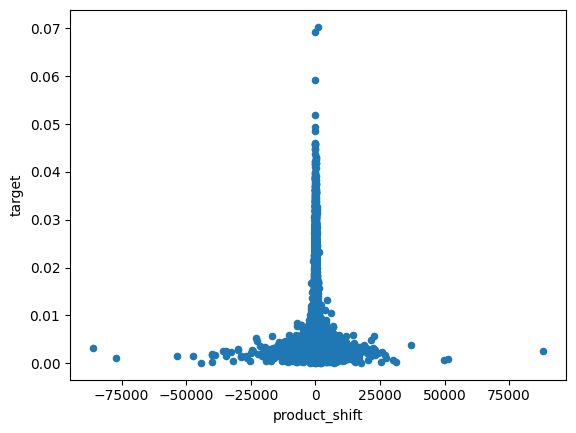

In [36]:
df.plot.scatter(x='product_shift',y='target')

<Axes: xlabel='shift_ratio', ylabel='target'>

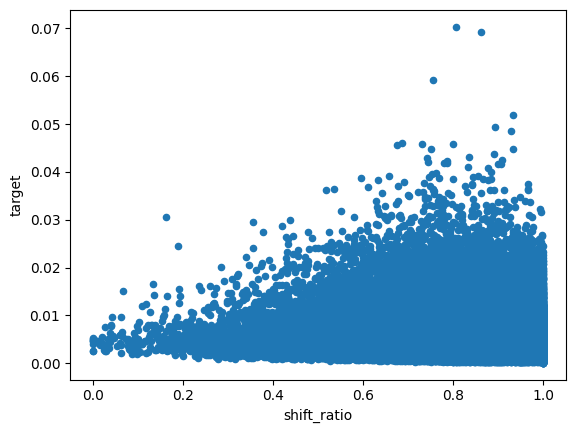

In [37]:
df.plot.scatter(x='shift_ratio',y='target')

In [38]:
df.corr().target

stock_id                  -0.021662
time_id                   -0.010341
sigma                      0.873780
target                     1.000000
size                       0.036413
spread                     0.753375
time_diff                  0.031866
log_time_diff              0.065225
timefunc                   0.064945
product_shift              0.000044
product_shift_abs          0.022427
w_spread                   0.729403
total_book_size           -0.061399
book_density_abs_impact    0.310983
shift_ratio               -0.233866
Name: target, dtype: float64

<Axes: xlabel='book_density_abs_impact', ylabel='target'>

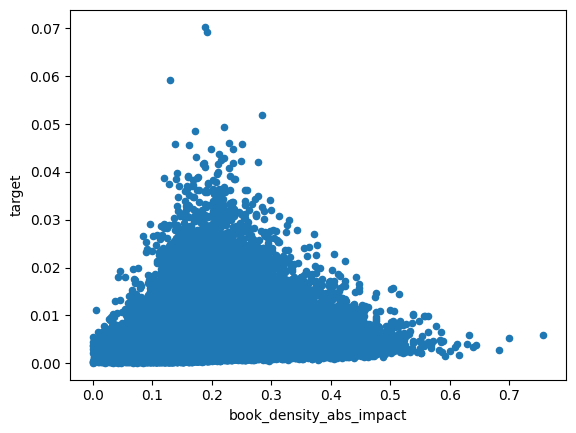

In [39]:
df.plot.scatter(x='book_density_abs_impact',y='target')